In [43]:
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter
from datetime import datetime

import geopandas as gpd
import shapely.geometry
import rasterio
import json
import geopandas as gpd
import geopandas_osm.osm
from descartes import PolygonPatch
import h5py 
from scipy.misc import imresize
import shapely.geometry
import tensorflow as tf
import cv2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [44]:
INPUT_SIZE = 240 

#helper functions:
def scale_bands(img, lower_pct = 1, upper_pct = 99):
    """Rescale the bands of a multichannel image for display"""
    img_scaled = np.zeros(img.shape, np.uint8)
    for i in range(img.shape[2]):
        band = img[:, :, i]
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        band = (band - lower) / (upper - lower) * 255
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
    return img_scaled

def resize(image, new_shape):
    #img_resized = np.zeros(new_shape+(img.shape[2],)).astype('float32')
    #for i in range(img.shape[2]):
    #    img_resized[:, :, i] = imresize(img[:, :, i], new_shape, interp='bicubic')
    #img_resized = cv2.resize(img,dsize=(new_shape,new_shape))
    

    r = new_shape / (1.0*image.shape[1])
    dim = (new_shape, int(image.shape[0] * r))

    # perform the actual resizing of the image and show it
    img_resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    
    #make training masks the proper dimensionality of only 1-D
    if len(image.shape) == 2: img_resized = np.expand_dims(img_resized,axis=2)
    
    return img_resized

### re-load the a training/testing set

In [45]:
# test/train split already done, load from files
#assumes image and mask files are of identical number and none are missing

In [55]:
# . TEMPORYARY KLUDGE FOR FILES NOT EXISTING YET
Xf_test = !ls /home/ubuntu/data/TX_post/training_tiles_v1/*img.npy
Yf_test  = !ls /home/ubuntu/data/TX_post/training_tiles_v1/*mask.npy
Xf_train = !ls /home/ubuntu/data/TX_post/training_tiles_v1/*img.npy
Yf_train  = !ls /home/ubuntu/data/TX_post/training_tiles_v1/*mask.npy

In [48]:
f = open('/home/ubuntu/Notebooks/test_train_filelists/test_images.txt', 'r')
Xf_test = f.readlines()
f = open('/home/ubuntu/Notebooks/test_train_filelists/test_masks.txt', 'r')
Yf_test = f.readlines()
f = open('/home/ubuntu/Notebooks/test_train_filelists/train_images.txt', 'r')
Xf_train = f.readlines()
f = open('/home/ubuntu/Notebooks/test_train_filelists/train_images.txt', 'r')
Yf_train = f.readlines()

IOError: [Errno 2] No such file or directory: '/home/ubuntu/Notebooks/test_train_filelists/test_images.txt'

In [49]:
print(len(Xf_train),len(Yf_train),len(Xf_test),len(Yf_test))

(4786, 4786, 4786, 4786)


In [50]:
#from training
def TT_split_resize(image_files,mask_files,out_res=240,split=0.8):
    X_train, Y_train, X_test, Y_test = [],[],[],[]
    size = len(image_files)
    indexes = range(size)
    dice_roll = np.random.random(size)
    for i,roll in enumerate(dice_roll):
        if roll < split:  #add to train
            X_train.append(resize(np.load(image_files[i]),out_res))
            Y_train.append(resize(np.load(mask_files[i]),out_res))
        if roll >= split: #add to test
            X_test.append(resize(np.load(image_files[i]),out_res))
            Y_test.append(resize(np.load(mask_files[i]),out_res))
    return np.array(X_train), np.array(Y_train), np.array(X_test), np.array(Y_test)

In [57]:
#just need to load/resize them now
def load_resize(image_files,mask_files,out_res=240):
    X,Y = [],[]
    for i in range(len(image_files)):
        X.append(resize(np.load(image_files[i]),out_res))
        Y.append(resize(np.load(mask_files[i]),out_res))
    return np.array(X), np.array(Y)

## MAKE THE TESTING AND TRAINGING DATA SETS

In [58]:
X_train, Y_train = load_resize(Xf_train,Yf_train)
X_test, Y_test = load_resize(Xf_test,Yf_test)
print(len(X_train),len(Y_train),len(X_test),len(Y_test))

(4786, 4786, 4786, 4786)


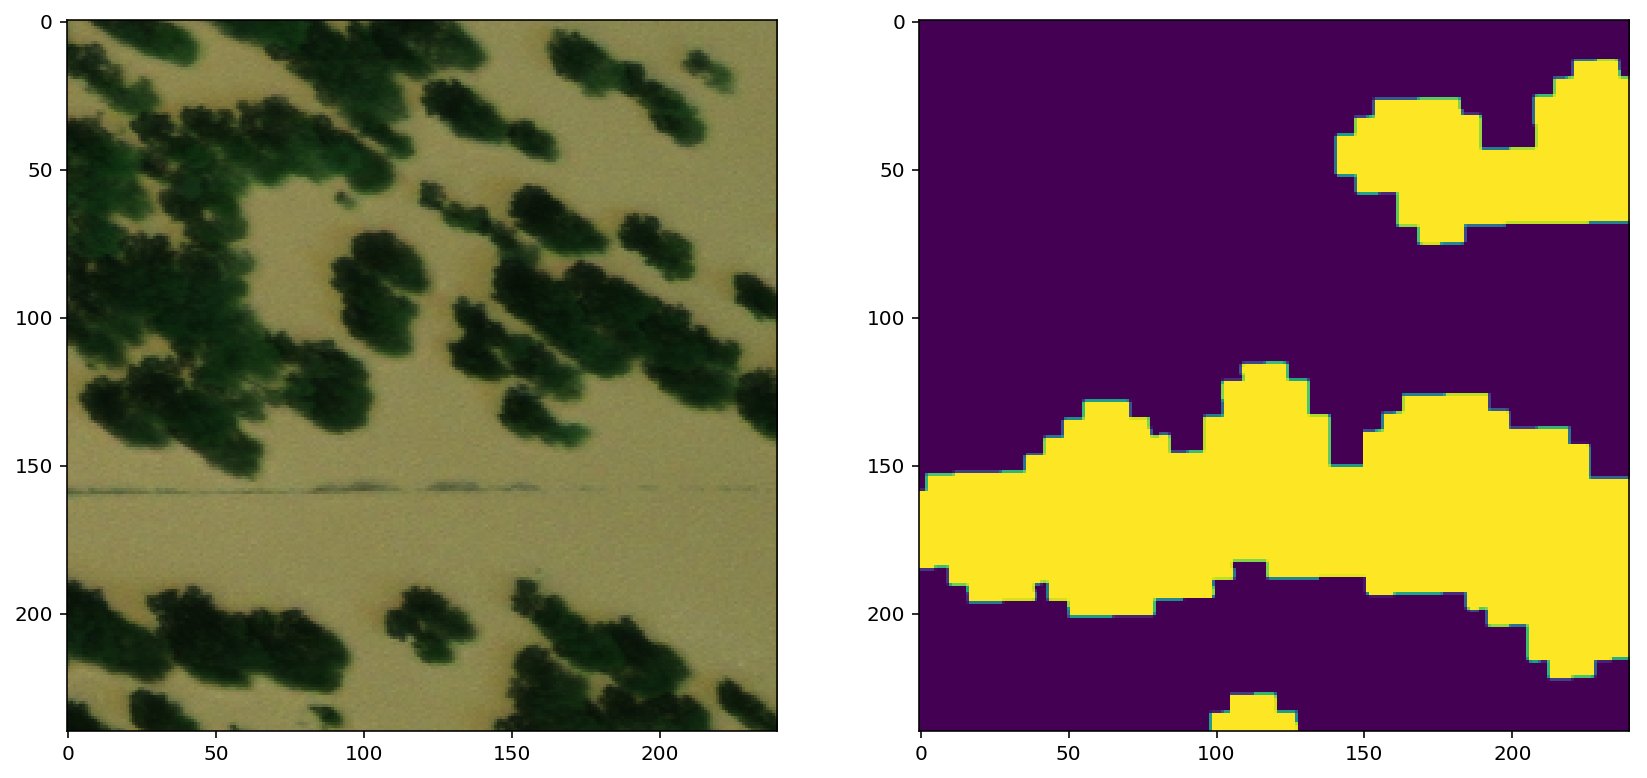

In [69]:
#display a random training image
n = np.random.randint(0,len(X_train)-1) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,14))
ax1.imshow(X_train[n])
ax2.imshow(Y_train[n][:,:,0]);

In [60]:
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((4786, 240, 240, 3),
 (4786, 240, 240, 1),
 (4786, 240, 240, 3),
 (4786, 240, 240, 1))

In [61]:
#this must be a huge dataset... how big exactly?
import sys
sys.getsizeof(X_train)

827020944

In [62]:
# Source: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py

import keras
from keras import backend as K
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.models import Model
from keras.optimizers import Adam

# Set network size params
N_CLASSES = 1
N_CHANNEL = 3

# Define metrics
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Just put a negative sign in front of an accuracy metric to turn it into a loss to be minimized
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacc_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def jacc_coef_loss(y_true, y_pred):
    return -jacc_coef(y_true, y_pred)

def jacc_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def get_unet(lr=0.001):
    inputs = Input((INPUT_SIZE, INPUT_SIZE, N_CHANNEL))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(N_CLASSES, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    # model.compile(optimizer=Adam(lr=lr), loss=jacc_coef_loss, metrics=[jacc_coef_int])
    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[jacc_coef_int])
    # model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[dice_coef])

    return model


## View some output
Now I'll test out the model by testing it on a single image and looking at the ground truth against the model prediction.

In [105]:
# Function to create an iterator with examples
def get_examples():
    for i in range(Y_test.shape[0]):
        if Y_test[i, ...].sum() > 3000:
            X = X_test[i]
            Y = Y_test[i]
            yield X, Y

# Function to plot a single example
def plot_example_class(X, Y, model,n_classes=1):
    # Apply the model to this example
    prediction = model.predict(X[None, ...])[0, ...] > 0.15
    
    fig, axes = plt.subplots(n_classes,3, figsize=(18,8))
    
    # Iterate through each target class
    print(Y.shape)
    for tno in range(n_classes):
        print(tno)
        targ = Y[:, :, tno]
        pred = prediction[:, :, tno]

        if n_classes == 1: ax1, ax2, ax3 = axes[:] #axes[tno,:]
        else: ax1, ax2, ax3 = axes[tno,:]

        #ax1.imshow(scale_bands(X[:, :, [4,2,1]])) # This index starts at 0, so I had to decrement
        ax1.imshow(X)
        ax2.imshow(targ, vmin=0, vmax=1)
        ax3.imshow(pred, vmin=0, vmax=1)

        ax1.set_title('Image')
        ax2.set_title('Ground Truth')
        ax3.set_title('Prediction')
    plt.show()

In [106]:
!ls checkpoints/

weights.00--131.08638.hdf5  weights.01--726.59569.hdf5
weights.00--726.59568.hdf5  weights.03--726.59567.hdf5
weights.00--928.65786.hdf5  weights.17--726.59569.hdf5
weights.01--131.08636.hdf5  weights.27--726.59569.hdf5


In [107]:
# # If you need to load the model, you can use these lines.  Change the weights filename to match one you have.
model = get_unet()
model.load_weights('checkpoints/weights.27--726.59569.hdf5')


example_generator = get_examples()

Now lets show a few examples.  Each row shows a target class.  Yellow areas are positive, and purple areas are negative.  At this point, you will begin to see that OSM data isn't always accurate.
**Top row**: Residential
**Middle row**: Forest
**Top row**: Water

(240, 240, 1)
0


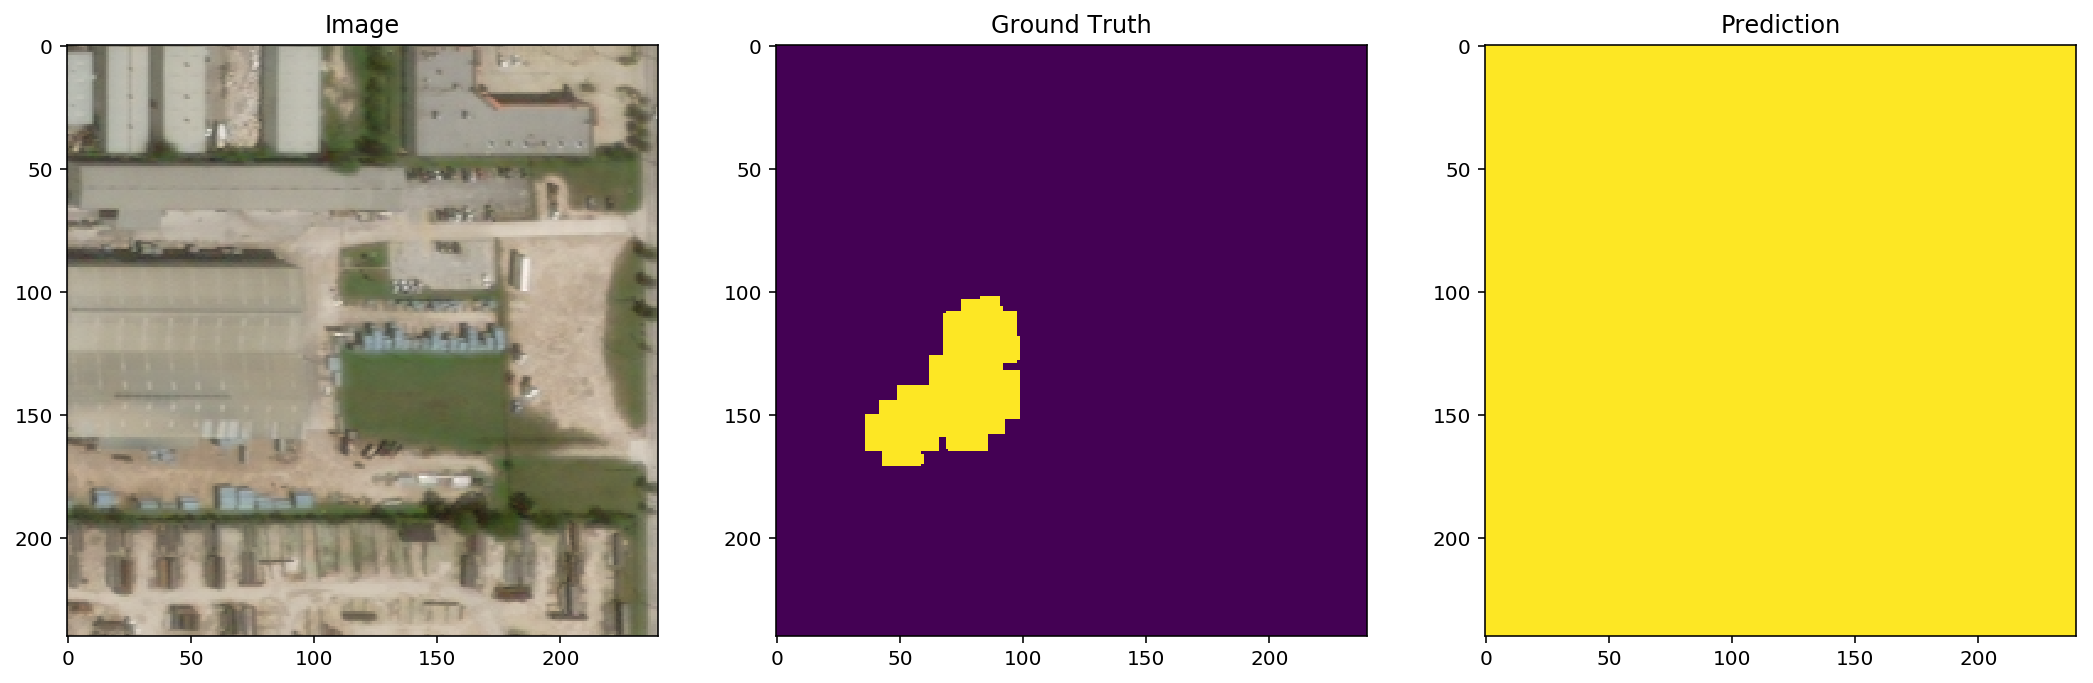

In [114]:
X_ex, Y_ex = next(example_generator)
plot_example_class(X_ex, Y_ex, model)

You'll notice that the validation loss is generally decreasing over all the training epochs, and then it eventually goes up a little and then plateaus at 0.0713, with a corresponding validation jaccard coefficient of 0.6682.  This is our final model, although if we want we can go back and grab previous states of the model.  They're all saved in the `checkpoints/` directory.

I should issue a word of caution at this point.  I was in a hurry to put this notebook up and I made a few mistakes in my data processing.  I already caught two whoppers that were totally messing up the training, and there might be more.

In [67]:
## View some output
Now I'll test out the model by testing it on a single image and looking at the ground truth against the model prediction.

# Function to create an iterator with examples
def get_examples():
    for i in range(Y_test.shape[0]):
        if Y_test[i, ...].sum() > 3000:
            X = X_test[i]
            Y = Y_test[i]
            yield X, Y

# Function to plot a single example
def plot_example(X, Y, model):
    # Apply the model to this example
    prediction = model.predict(X[None, ...])[0, ...] > 0.15
    
    fig, axes = plt.subplots(3,3, figsize=(10,10))
    
    # Iterate through each target class
    for tno in range(3):
        targ = Y[:, :, tno]
        pred = prediction[:, :, tno]

        ax1, ax2, ax3 = axes[tno,:]

        ax1.imshow(scale_bands(X[:, :, [4,2,1]])) # This index starts at 0, so I had to decrement
        ax2.imshow(targ, vmin=0, vmax=1)
        ax3.imshow(pred, vmin=0, vmax=1)

        ax1.set_title('Image')
        ax2.set_title('Ground Truth')
        ax3.set_title('Prediction')
    plt.show()


# # If you need to load the model, you can use these lines.  Change the weights filename to match one you have.
model = get_unet()
model.load_weights('checkpoints/weights.99-0.07128.hdf5')


example_generator = get_examples()


Now lets show a few examples.  Each row shows a target class.  Yellow areas are positive, and purple areas are negative.  At this point, you will begin to see that OSM data isn't always accurate.
**Top row**: Residential
**Middle row**: Forest
**Top row**: Water

X, Y = next(example_generator)
plot_example(X, Y, model)

SyntaxError: invalid syntax (<ipython-input-67-0cdb1776fc46>, line 1)